# Image Classification Task
1. Train 2 different models and get results.<br>
      1.1. Download the image classification data. <br>
      1.2. Train a classification model (using PyTorch or Tensorflow) to classify the tissue images into organ systems they come from. (Do not use a pre-trained model. You should create a model and a dataloader from scratch.)<br>
      1.3. Train a classification model (using Pytorch or Tensorflow) to classify the tissue images into organ systems they come from. Use a pre-trained model such as VGG, Inception, Efficientnet etc. You may use in-built functions to create your model and dataloader.<br>
      1.4. Calculate the training and test accuracy of your model. <br>
2. Visualize <br>
      2.1. Overlap between training and test datasets in 2D, e.g., using t-SNE, UMAP, MDS etc. <br>
      2.2. Prediction results <br>
3. Explain why some images might have been classified incorrectly.
4. Read a paper and write a 1-page (500 words) summary. (Paper Drive link: https://drive.google.com/file/d/1p1g76HBOIa8qpGQzattBmOgBno933lPt/view?usp=sharing Paper Nature link: https://www.nature.com/articles/s41592-019-0403-1 )

# 1. Train 2 different models and get results

## 1.1 Download the image classification data.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd './drive/MyDrive/ml_hiring_data'

/content/drive/MyDrive/ml_hiring_data


In [3]:
! pwd

/content/drive/MyDrive/ml_hiring_data


In [4]:
#importing libraries

import torch
from torch import autograd
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imutils
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import copy
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 1.1.1 Loading the data using Custom DataLoader Class of pytorch

In [9]:
class DataLoaderCustom(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        folders = os.listdir(root_dir)
        self.labels = []
        self.img_path = []
        for f in folders:
          path = os.path.join(root_dir, f + '/')
          img_path = os.listdir(path)
          for img_p in img_path:
            self.labels.append(f)
            self.img_path.append(path + img_p)

        self.order = [self.labels[i] for i in range(1, len(self.labels)) if self.labels[i-1] != self.labels[i]]
        self.order = [self.labels[0]] + self.order

    def __len__(self):
        return len(self.labels)

    def get_ohe_label(self, label):
      ret = np.zeros(len(self.order))
      ret[self.order.index(label)] = 1
      return torch.tensor(ret)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = cv2.imread(self.img_path[idx])
        img = cv2.resize(img,(224,224)) 
        true_label = self.labels[idx]
        label = self.get_ohe_label(true_label)
        sample = {'image': img, 'label': label, 'true_label': true_label}

        if self.transform:
            sample['image'] = self.transform(Image.fromarray(sample['image']))
            sample['image'] = transforms.functional.adjust_sharpness(sample['image'],sharpness_factor=5)

        return sample

In [10]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(90), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(90),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

trainset = DataLoaderCustom(root_dir='/content/drive/MyDrive/ml_hiring_data/data/train/', transform=transform_train)
testset = DataLoaderCustom(root_dir='/content/drive/MyDrive/ml_hiring_data/data/test/', transform=transform_test)

batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [11]:
dataiter = iter(trainloader)
data = dataiter.next()

print('Size of Batched data = ', data['image'].shape)

print('Size of Batched data Images  = ', data['image'][1].shape)
print('True Label = ', data['true_label'][1])
print('One Hot encoded Label = ', data['label'][1])


error: ignored

In [ ]:
print('Total number of images in train dataset = ', len(trainset))
print('Total number of images in test dataset = ', len(testset))

# The dataset is balanced
sns.countplot(trainset.labels)
plt.xticks(rotation=90)
plt.show()

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12,15))

temp = 0
for i in range(4):
  for j in range(4):
    axs[i, j].imshow(np.transpose(data['image'][temp].numpy() / 2 + 0.5, (1, 2, 0)))
    axs[i, j].set_title(data['true_label'][temp])
    temp+=1

plt.show()

Loading the data using the DataLoader class will take a lot of time because dataloader does not save the image into memory once loaded. therefore it will again and again make a call to the google drive to load the image which will increces the time due to I/O.

### 1.1.2 Loading the data using custom loader that store the data in momory at once

In [ ]:
# custom dataset loader(NOTE: this changes with different datasets)
def dataloader(dir, tot = None):  
    images = []
    labels = []
    path_list = []
    folders = os.listdir(dir)
    # loading the folders inside train
    for f in folders:
      path = os.path.join(dir, f + '/')
      img_path = os.listdir(path)
      # loading the images inside the folders
      for img_p in img_path:
        path_list.append((path + img_p, f))
    
    random.shuffle(path_list)  
    for x in tqdm(path_list):
      img = cv2.imread(x[0])
      img = cv2.resize(img,(224,224))                 #resize all the image to 224,224,3 which vgg16 accepts
      images.append(img)
      labels.append(x[1])
      
      # data Augmentation
      if random.randint(1, 50) % 10 == 0:
        images.append(cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE))
        labels.append(f)
      elif random.randint(1, 50) % 8 == 0:
        images.append(cv2.rotate(img, cv2.cv2.ROTATE_180))
        labels.append(f)
      elif random.randint(1, 50) % 6 == 0:
        images.append(cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
        labels.append(f)
      elif random.randint(1, 50) % 4 == 0:
        images.append(cv2.flip(img, 0))
        labels.append(f)
      elif random.randint(1, 50) % 2 == 0:
        images.append(cv2.flip(img, -1))
        labels.append(f)
      elif random.randint(1, 50) % 12 == 0:
        images.append(cv2.flip(img, 1))
        labels.append(f)

      if tot:
        if len(labels) > tot:
          return torch.tensor(images), labels
    return torch.tensor(images), labels 

In [ ]:
def get_ohe_label(labels, idx = None):
  if idx is None:
    idx = list(set(labels))

  label = [idx.index(x) for x in labels]

  return torch.nn.functional.one_hot(torch.tensor(label)), idx

In [13]:
images, label = dataloader('/content/drive/MyDrive/ml_hiring_data/data/train/')
images_test, label_test = dataloader('/content/drive/MyDrive/ml_hiring_data/data/test/')

100%|██████████| 600/600 [27:05<00:00,  2.71s/it]


### Visializing the data

Total number of images in train dataset =  2114
Total number of images in test dataset =  1063


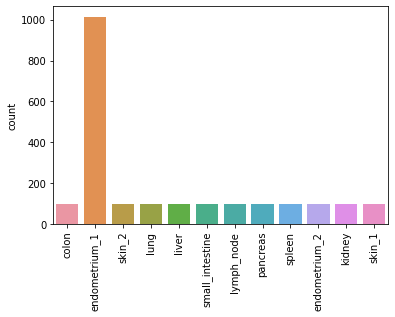

In [14]:
print('Total number of images in train dataset = ', len(images))
print('Total number of images in test dataset = ', len(images_test))

# The dataset is balanced
sns.countplot(label)
plt.xticks(rotation=90)
plt.show()

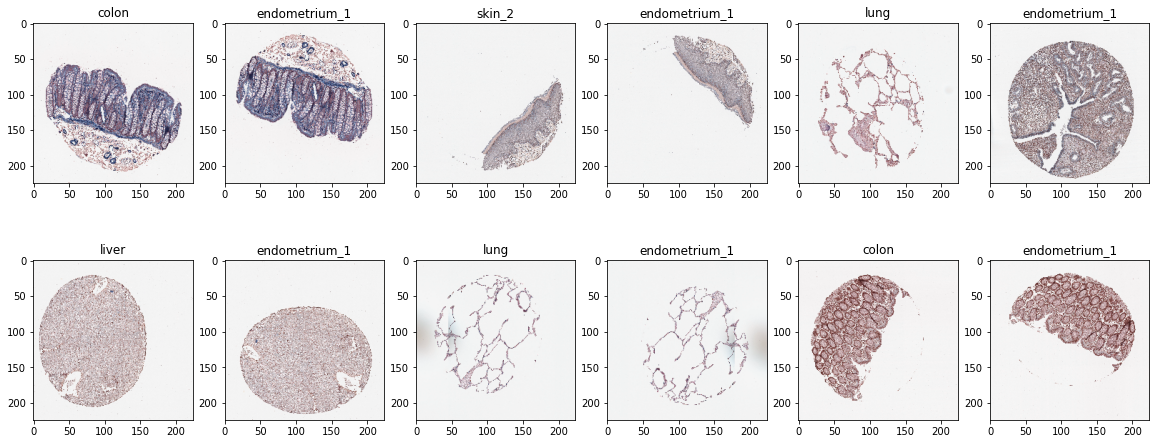

In [15]:
index = [i for i in range(1, len(label)) if label[i-1] != label[i]]
index = [0] + index

fig, axs = plt.subplots(2, 6, figsize=(20,8))

temp = 0
for i in range(2):
  for j in range(6):
    axs[i, j].imshow(images[index[temp]])
    axs[i, j].set_title(label[index[temp]])
    temp+=1

plt.show()


In [16]:
labels, order = get_ohe_label(label)
images, labels = images.to(device), labels.to(device)

labels_test, _ = get_ohe_label(label_test, order)
images_test, labels_test = images_test.to(device), labels_test.to(device)

## 1.2 Train a classification model (using PyTorch or Tensorflow) to classify the tissue images into organ systems they come from. (Do not use a pre-trained model. You should create a model and a dataloader from scratch.)

In [17]:
class Classifier(nn.Module):
    def __init__(self): 
        super(Classifier, self).__init__()
        
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),           # (N, 3, 224, 224) -> (N,  6, 220, 220)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, stride=2),    # (N, 6, 220, 220) -> (N,  6, 110, 110)
            nn.Conv2d(6, 16, 5),          # (N, 6, 110, 110) -> (N, 16, 106, 106)  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2),    # (N,16, 106, 106) -> (N, 16, 53, 53)
            nn.Conv2d(16, 16, 5),         # (N, 16, 53, 53) -> (N, 16, 48, 48)  
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2),    # (N,16, 48, 48) -> (N, 16, 24, 24)
            nn.Conv2d(16, 16, 5),         # (N, 16, 24, 24) -> (N, 16, 20, 20)  
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2)     # (N,16, 20, 20) -> (N, 16, 10, 10)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(1600,800),          # (N, 1600) -> (N, 800)
            nn.Dropout(0.05),
            nn.Linear(800,400),          # (N, 800) -> (N, 400)
            nn.Dropout(0.05),
            nn.Linear(400, 120),          # (N, 400) -> (N, 120)
            nn.Dropout(0.05),
            nn.Linear(120,50),            # (N, 120) -> (N, 50)
            nn.Dropout(0.05),
            nn.Linear(50,12)              # (N, 50)  -> (N, 12)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_model(x)
        return x

In [18]:
def evaluation(images, labels, net):
    total, correct = 0, 0
    for data, l in zip(images, labels):
        data = data/255
        outputs = net(torch.unsqueeze(data.permute(2, 1, 0), 0).to(torch.float))
        _, pred = torch.max(outputs.data, 1)
        _, l = torch.max(l, 0)
        total += 1
        correct += (pred == l).sum().item()
    return 100 * correct / total

In [41]:
old = True

In [42]:
net = Classifier()

if old:
  # load trained from drive--/content/drive/My Drive/
  net.load_state_dict(torch.load('/content/drive/MyDrive/cns_ml_hiring_custom.pth', map_location= 'cpu')) 

net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.005)

Epoch: 0/5, Test acc: 42.43, Train acc: 40.68
Epoch: 1/5, Test acc: 38.48, Train acc: 39.64
Epoch: 2/5, Test acc: 45.72, Train acc: 45.18
Epoch: 3/5, Test acc: 39.42, Train acc: 38.55
Epoch: 4/5, Test acc: 47.98, Train acc: 46.36


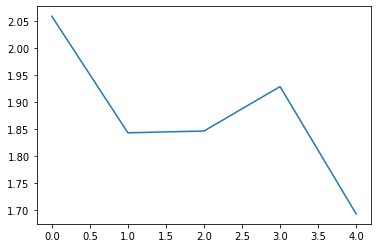

In [43]:
#%%time

loss_epoch_arr = []
max_epochs = 5
batch = 8
min_loss = 9999

for epoch in range(max_epochs):
    loss_arr = []
    arr = list(range(len(labels)))
    random.shuffle(arr)
    for k in range(0, len(labels), batch):
        data, l = images[arr[k:k+batch]], labels[arr[k:k+batch]]
        data = data/255.0
        data, l  = torch.tensor(data), torch.tensor(l)
        
        opt.zero_grad()
        
        outputs = net(data.permute(0, 3, 1, 2).to(torch.float))
        _, l = torch.max(l,1)
        
        loss = loss_fn(outputs, l.to(torch.long))
        
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
        
    loss_epoch_arr.append(sum(loss_arr)/len(loss_arr))

    if min_loss > sum(loss_arr)/len(loss_arr):
          min_loss = sum(loss_arr)/len(loss_arr)
          best_model = copy.deepcopy(net)
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch,max_epochs,evaluation(images_test,labels_test,net),evaluation(images,labels,net)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [44]:
if not old:
  torch.save(best_model.state_dict(), '/content/drive/MyDrive/cns_ml_hiring_custom.pth')

In [45]:
net = Classifier()
net.load_state_dict(torch.load('/content/drive/MyDrive/cns_ml_hiring_custom.pth', map_location= 'cpu')) 
net.to(device)

print('Training Accuracy on Custom model = ', evaluation(images, labels))
print('Test Accuracy on Custom model = ', evaluation(images_test, labels_test))

Training Accuracy on Custom model =  15.894039735099337
Test Accuracy on Custom model =  15.992474129821261


In [46]:
pred_test_c = []
l_test_c = []
for data, l in zip(images_test, labels_test):
    data = data/255
    outputs = net(torch.unsqueeze(data.permute(2, 1, 0), 0).to(torch.float))
    _, pred = torch.max(outputs.data, 1)
    _, l = torch.max(l, 0)
    pred_test_c.append(order[pred])
    l_test_c.append(order[l.item()])

## 1.3. Train a classification model (using Pytorch or Tensorflow) to classify the tissue images into organ systems they come from. Use a pre-trained model such as VGG, Inception, Efficientnet etc. You may use in-built functions to create your model and dataloader.

In [47]:
class Classifier_vgg(nn.Module):
    def __init__(self): 
        super(Classifier_vgg, self).__init__()

        self.cnn_model = models.vgg16_bn(pretrained=True)
        # for param in self.cnn_model.parameters():
        #   param.requires_grad = False 
        self.final_in_features = self.cnn_model.classifier[6].in_features
        self.cnn_model.classifier[6] = nn.Linear(self.final_in_features, 12)

        
    def forward(self, x):
        x = self.cnn_model(x)
        return x

In [48]:
old = False

In [49]:
net = Classifier_vgg()
if old:
  # load trained from drive--/content/drive/My Drive/
  net.load_state_dict(torch.load('/content/drive/MyDrive/cns_ml_hiring_vgg.pth', map_location= 'cpu')) 

net.to(device)
loss_fn = nn.CrossEntropyLoss()
# opt = optim.Adam(net.parameters())
opt = optim.SGD(net.parameters(), lr=0.05)

In [ ]:
#%%time

loss_epoch_arr = []
max_epochs = 5
batch = 8
min_loss = 9999

for epoch in range(max_epochs):
    loss_arr = []
    arr = list(range(len(labels)))
    random.shuffle(arr)
    for k in range(0, len(arr), batch):
        data, l = images[arr[k:k+batch]], labels[arr[k:k+batch]]
        data = data/255.0
        data, l  = torch.tensor(data), torch.tensor(l)
        opt.zero_grad()
        
        outputs = net(data.permute(0, 3, 1, 2).to(torch.float))
        
        _, l = torch.max(l,1)
        
        loss = loss_fn(outputs, l)
        
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
        
    loss_epoch_arr.append(sum(loss_arr)/len(loss_arr))

    if min_loss > sum(loss_arr)/len(loss_arr):
          min_loss = sum(loss_arr)/len(loss_arr)
          best_model = copy.deepcopy(net)
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'%(epoch,max_epochs,evaluation(images_test,labels_test),evaluation(images,labels)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

Epoch: 0/5, Test acc: 48.26, Train acc: 47.97


In [38]:
if not old:
  torch.save(best_model.state_dict(), '/content/drive/MyDrive/cns_ml_hiring_vgg.pth')

In [40]:
net = Classifier()
net.load_state_dict(torch.load('/content/drive/MyDrive/cns_ml_hiring_vgg.pth', map_location= 'cpu')) 
net.to(device)

print('Training Accuracy on VGG model = ', evaluation(images, labels))
print('Test Accuracy on VGG model = ', evaluation(images_test, labels_test))

RuntimeError: ignored

In [ ]:
pred_test_v = []
l_test_v = []
for data, l in zip(images_test, labels_test):
    data = data/255
    outputs = net(torch.unsqueeze(data.permute(2, 1, 0), 0).to(torch.float))
    _, pred = torch.max(outputs.data, 1)
    _, l = torch.max(l, 0)
    pred_test_v.append(order[pred])
    l_test_v.append(order[l.item()])

# 2. Visualize

## 2.1 Overlap between training and test datasets in 2D, e.g., using t-SNE, UMAP, MDS etc.

In [50]:
images.shape

torch.Size([101, 224, 224, 3])

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(images.reshape(images.shape[0], -1))

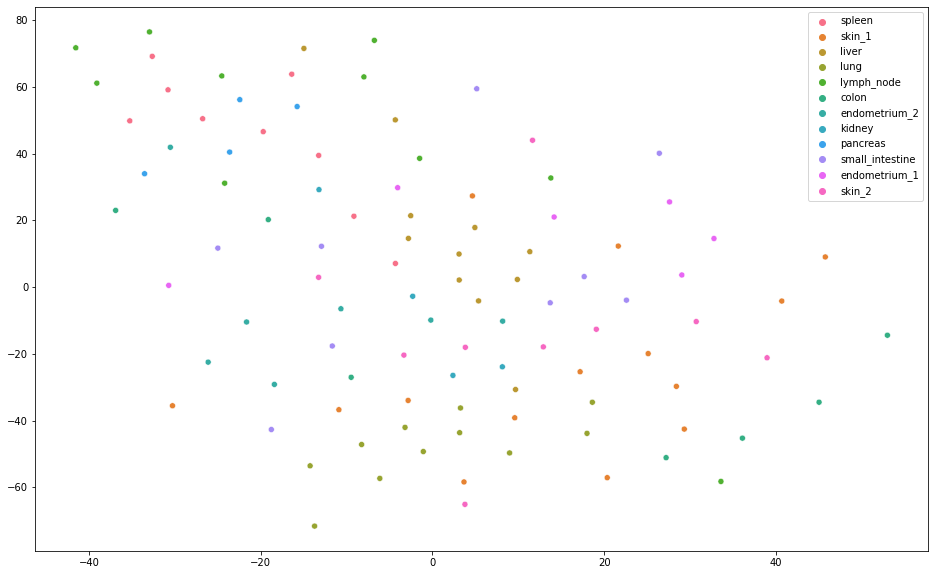

In [85]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne[:,0], y=tsne[:,1],
    hue=label
)

## 2.2. Prediction results

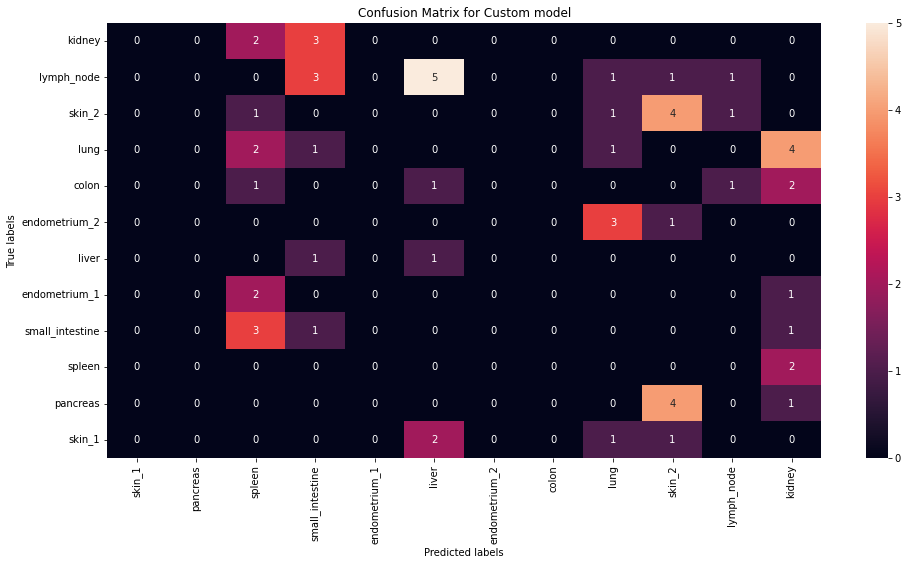

In [87]:
plt.figure(figsize=(16,8))
cm = confusion_matrix(y_true = l_test_c, y_pred = pred_test_c, labels = order)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Custom model')
ax.xaxis.set_ticklabels(order)
ax.yaxis.set_ticklabels(order[::-1])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
cm = confusion_matrix(y_true = l_test_v, y_pred = pred_test_v, labels = order)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for VGG model')
ax.xaxis.set_ticklabels(order)
ax.yaxis.set_ticklabels(order[::-1])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# 3. Explain why some images might have been classified incorrectly.